# **Part I** : **Analysis**
# Question 1 - Is it possible to relate the characteristics of a place with its quality??
## Graphical **Analysis** of features of the house X Review rate score

#### Importing and Reading the Datasets

In [1]:
import spacy
import pandas as pd
from nltk import FreqDist
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
df_listing_boston = pd.read_csv('listings.csv')
df_listing_seattle = pd.read_csv('listings_2.csv')
df_listing = pd.concat([df_listing_boston,df_listing_seattle],axis = 0).reset_index(drop=True)

#### Let's take only the the samples with number of reviews greater than 20

In [3]:
df_listing_20 = df_listing[df_listing.number_of_reviews>20].sort_values(by=['review_scores_rating','number_of_reviews',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value'])

### For our analysis we are going plot charts to undertand what is more atractives in houses

#### To a general overview, we plot the comparison of some characteristics x score_rating

##### Price is a string, so we need first preprocess the price removing some caracteres and converting to Float

In [4]:
df_listing_20.price = df_listing_20.price.apply(lambda x: x.replace('$','').replace(',',''));
df_listing_20.price = df_listing_20.price.astype(float);

In [5]:
def plot_scatter(df):
    """Plot charts of beds, bathroom, bedrooms, accomodates and price X review_scores_rating
    Args:
        df: Dataframe
    """
    df.plot(x='beds',y='review_scores_rating',kind='scatter',subplots=True); #Plot of beds x review_scores_rating
    df.plot(x='bedrooms',y='review_scores_rating',kind='scatter',subplots=True); #Plot of bedrooms x review_scores_rating
    df.plot(x='bathrooms',y='review_scores_rating',kind='scatter',subplots=True); #Plot of bathrooms x review_scores_rating
    df.plot(x='accommodates',y='review_scores_rating',kind='scatter',subplots=True); #Plot of accomodates x review_scores_rating
    df.plot(x='price',y='review_scores_rating',kind='scatter',subplots=True);

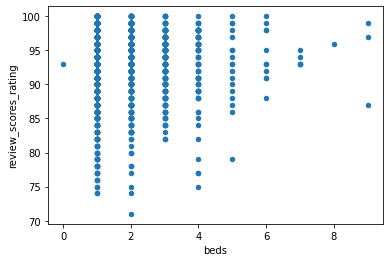

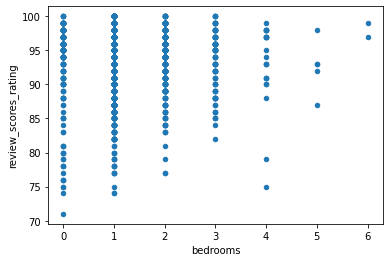

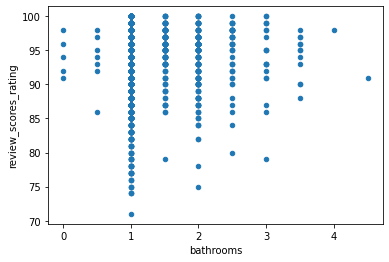

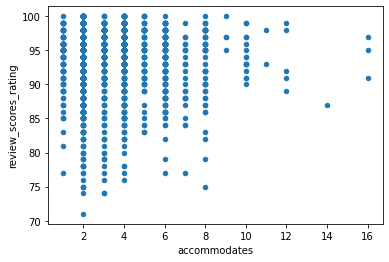

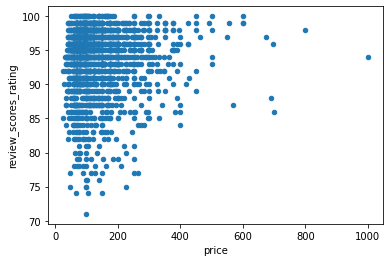

In [6]:
plot_scatter(df_listing_20) #Call function to plot all charts

<AxesSubplot:xlabel='property_type'>

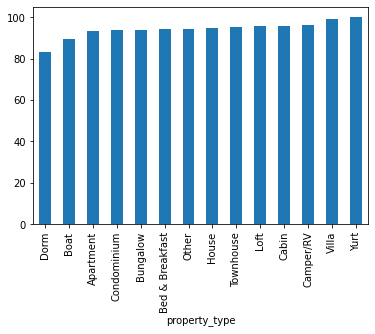

In [7]:
df_listing_20.groupby(['property_type']).mean()['review_scores_rating'].sort_values().plot(kind='bar') #Plot of Mean review_score_rate per property_type

In [8]:
df_cheap = df_listing_20[(df_listing_20.price < 200)] #Get a list of places with price less than 200 USD

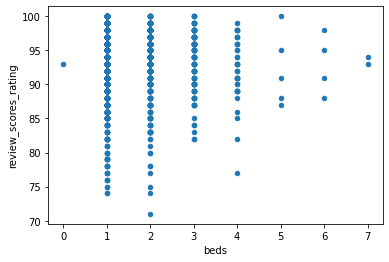

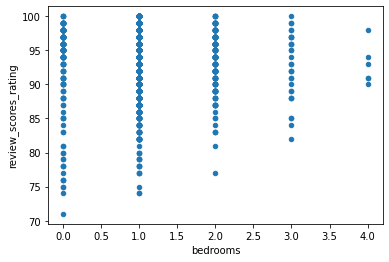

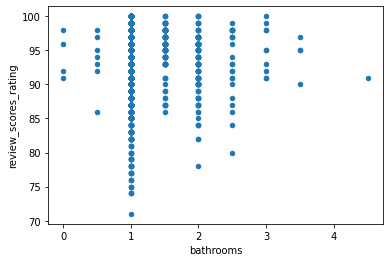

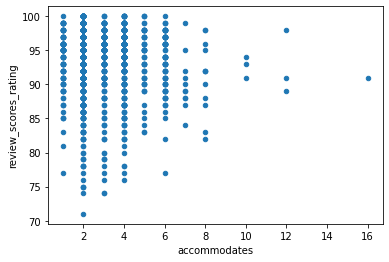

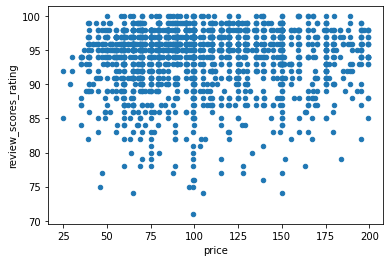

In [9]:
plot_scatter(df_cheap)

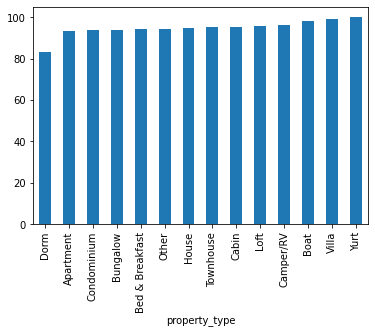

In [10]:
df_cheap.groupby(['property_type']).mean()['review_scores_rating'].sort_values().plot(kind='bar');#Plot of Mean review_score_rate per property_type

# **Part II**: **Modeling and Evaluation**
# Question 2- Is it possible to infer the quality of a place based on its characteristics?
## In this Part we are going to predict the quality of a place based on characteristics of your choice
### We drop rows with NaN values in reviews_scores_rating which is the target

In [11]:
df_features = df_listing.dropna(subset=['review_scores_rating'],axis=0)[['property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'price']]

In [12]:
dummies = pd.get_dummies(df_features[['property_type','room_type','bed_type']]) #One hot encode the categorical variables

In [13]:
df_features = pd.concat([df_features.drop(columns = ['property_type','room_type','bed_type']),dummies ],axis=1) #Concatenate the Dataframe with the dummies

In [14]:
for col in df_features[['accommodates','bathrooms', 'bedrooms', 'beds','price']]:
    df_features[col] = df_features.fillna(lambda x: x[col].mode()) #Filling the NaN Values with the mode

##### Price is a string, so we need first preprocess the price removing some caracteres and converting to Float

In [15]:
y = df_listing.review_scores_rating.dropna() #Drop the NaN Values of our target

In [16]:
x_train, x_test, y_train, y_test = train_test_split(df_features, y, test_size=0.2, random_state=42, shuffle=True)#Separate the dataset in train and test
rf_model = GradientBoostingRegressor() #Instantiate the model

In [17]:
rf_model.fit(x_train,y_train) #Fit de mothel

GradientBoostingRegressor()

In [18]:
predictions = rf_model.predict(x_test) # Assign tthe predictions to the predictions variable

In [19]:
mean_absolute_error(y_test, predictions)# Mean Absolute error

5.587034764470511

#### To plot and compare the graphics, first we need to reduce our features from 32 to 1, we can do this using PCA from sklearn

In [20]:
pca = PCA(n_components=1)
x = pca.fit_transform(x_test)

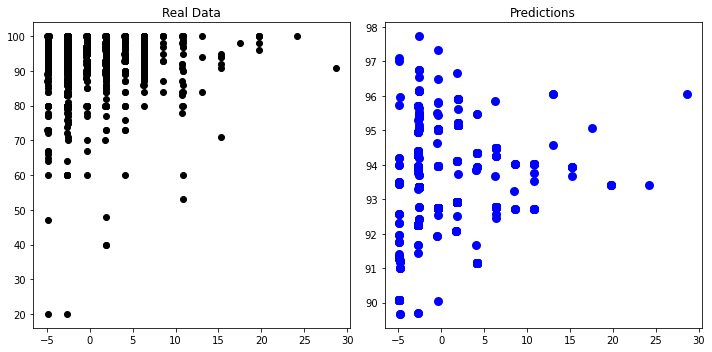

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].scatter(x, y_test,  color='black')
axes[0].set_title('Real Data')
axes[1].scatter(x, predictions,color='blue', linewidth=3)
axes[1].set_title('Predictions')
fig.tight_layout()

# **Part III**
# Question 3 - For me as a landlord, is it possible to see my main strengths and weaknesses based on the reviews?
## In this part our analysis will be focused on the Boston Dataset
## let's see in the comments what users say most  after renting a house.

#### For this part we are going to use SpacyTextBlob for sentiment analysis

In [22]:
nlp = spacy.load('en_core_web_sm') #Loading the model
nlp.add_pipe('spacytextblob') #add Sentiment Analysis in the pipeline

### We need to drop reviews with no comments, because spacy doesn't know how to interpret NaN values.

In [23]:
df_reviews = pd.read_csv('reviews.csv')
df_reviews = df_reviews.dropna(subset=["comments"]) 

In [24]:
ids = df_listing_20.id

In [25]:
def get_reviews_by_id(df, ids):
    """This Function get a DataFrame a Locations IDs and return the comments of this location
    Args:
        df: a Dataframe
        ids: list of Ids"""
    reviews = []
    for unique_id in ids:
        reviews = reviews + list(df.comments[df.listing_id == unique_id].values)
    return reviews

In [26]:
def get_keywords(reviews, positive=True):
    """This function get a list of Reviews and return the positive or negative keywords
    Args:
        reviews: List of reviews to be analyzed
        positive: If Keywords to be filtered are positive or negative
        """
    keywords = []
    for review in nlp.pipe(reviews):
        for assessments in review._.assessments:
            if positive and assessments[1] > 0.3:
                keywords.append(' '.join(assessments[0]))
            elif not positive and assessments[1] < -0.3:
                keywords.append(' '.join(assessments[0]))
    return keywords

In [27]:
reviews = get_reviews_by_id(df_reviews, ids)

In [28]:
positive_keywords= get_keywords(reviews, positive=True)

In [29]:
negative_keywords = get_keywords(reviews, positive=False)

In [30]:
frequencys_positive = FreqDist(positive_keywords)

In [31]:
frequencys_negative = FreqDist(negative_keywords)

In [ ]:
dict(frequencys_negative)

In [ ]:
dict(frequencys_positive)

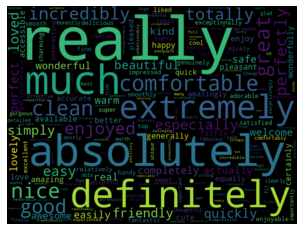

In [36]:
wordcloud = WordCloud(width=800, height=600).generate(' '.join(set(positive_keywords)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('positive_words.png')
plt.axis("off")
plt.show()

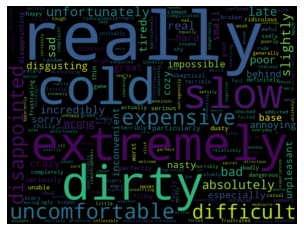

In [37]:
wordcloud = WordCloud(width=800, height=600).generate(' '.join(set(negative_keywords)))
plt.imshow(wordcloud, interpolation='bilinear')
plt.savefig('negative_words.png')
plt.axis("off")
plt.show()